## Hair Detection
In this work I will present my attemp to train a convolutional network that it could answer to a question "does an 32x32 RGB image present hair?". Presented model, trained for 5 minues on GeForce 960, has almost 99% accuracy on test data.

## Data 
My data comes from 32 images, that I found on internet. For each of them I created a mask saying if given pixel presents "hair" - green, "no_hair" - blue or "maybe_hair" - black. 
![title](image.jpg)
![title](mask.png)
You can download the dataset at this [link](https://drive.google.com/open?id=0B6SXqwuMpzmCdWp0QnVsczdoZ28). You can find there also a script to generate such subimages from image and the mask. 

## Data loading

In [1]:
import glob
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

hair_input_list = glob.glob("E:\\Desktop\\hair\\outputHair\\*.jpg")
no_hair_input_list = glob.glob("E:\\Desktop\\hair\\outputNoHair\\*.jpg")
number_to_load = min(len(hair_input_list), len(no_hair_input_list))

data = np.zeros(shape=(2*number_to_load,32,32,3),dtype=np.uint8)
target = np.empty(shape=(2*number_to_load,1),dtype=np.uint8)

for i in range(number_to_load):
    data[i] = cv2.cvtColor(cv2.imread(hair_input_list[i],cv2.IMREAD_COLOR), 
                           cv2.COLOR_BGR2RGB)
    target[i] = 1

for i in range(number_to_load):
    data[number_to_load+i] =  cv2.cvtColor(cv2.imread(no_hair_input_list[i],
                                cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    target[number_to_load+i] = 0
    
x_train, x_test, y_train, y_test = train_test_split(data, 
                                    target,test_size=0.33, random_state=43)

## Glance into data

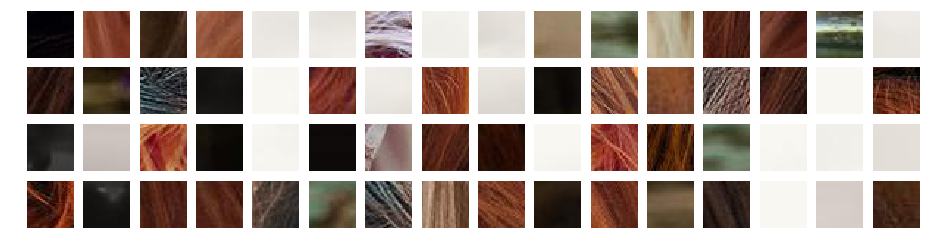

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,4))
for i in range(64):
    a=fig.add_subplot(4,16,i+1)
    plt.imshow(x_train[i])
    plt.axis('off')

## Model

In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.losses import binary_crossentropy
from keras.optimizers import Adadelta, Adam, Adagrad

model = Sequential()
model.add(Conv2D(48, kernel_size=(5, 5), input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(Conv2D(48, kernel_size=(3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(96, kernel_size=(3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(192, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(192, kernel_size=(3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])
print(model.summary())

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 48)        3648      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 48)        20784     
_________________________________________________________________
activation_2 (Activation)    (None, 26, 26, 48)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 48)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 96)        41568     
__________

## Training

In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
model.fit(x_train, y_train, batch_size=125, epochs=100, verbose=0, 
          validation_data=(x_test, y_test))

## Accuraccy

In [5]:
from sklearn.metrics import accuracy_score
print(accuracy_score(np.around(model.predict(x_train)), y_train))
print(accuracy_score(np.around(model.predict(x_test)), y_test))

0.998852947924
0.98695854681


## Final test
Let's check how does it work in real life! 
![title](finite_.jpg)

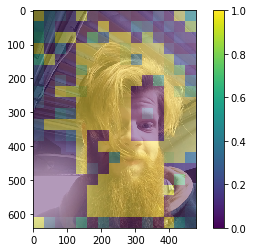

In [6]:
the_test = cv2.cvtColor(cv2.imread("E:\\Desktop\\hair\\finite_.jpg",
                                   cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

val = np.zeros((20,15))
for y in range(20):
    for x in range(15):
        img = the_test[32*y:32*y+32, 32*x:32*x+32]
        val[-y][x] = model.predict(np.array([img]))
plt.imshow(val,extent=[0,480,0,640])
plt.colorbar()
plt.imshow(the_test,alpha=0.6)
plt.show()

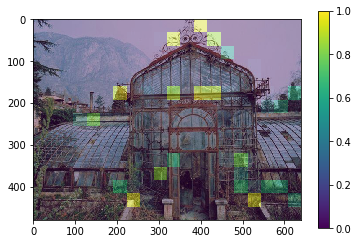

In [7]:
the_test = cv2.cvtColor(cv2.imread("E:\\Desktop\\hair\\nibyprzypadek.jpg",
                                   cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

val = np.zeros((15,20))
for y in range(15):
    for x in range(20):
        img = the_test[32*y:32*y+32, 32*x:32*x+32]
        val[-y][x] = model.predict(np.array([img]))
plt.imshow(val,extent=[0,640,0,480])
plt.colorbar()
plt.imshow(the_test,alpha=0.6)
plt.show()

As we can see it is not that ideal as 99% stated before. I belive it needs more data. Especially when it comes to hair-like images like grass or image like we see above - straight edge of my bed. 

Another point is that here I consider colored pictures.